In [1]:
from dataset_functions import from_path_to_dataloader
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
#plot   
import matplotlib.pyplot as plt

c:\Users\lucat\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#create the dataloaders
path_train = './chaoyang-data/train'
path_test = './chaoyang-data/test'
batch_size = 16

train_dataloader = from_path_to_dataloader(path_train, batch_size, True, True)
test_dataloader = from_path_to_dataloader(path_test, batch_size, False, False)

#split the train dataset into train and validation
train_size = int(0.9 * len(train_dataloader.dataset))
val_size = len(train_dataloader.dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataloader.dataset, [train_size, val_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#use the GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#use huggingface's pretrained model for image classification vit-base-patch16-224
#model = transformers.ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=1000)
# use huggingface's pretrained model for image classification swin-base-patch4-window7-224
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig
path_swin="microsoft/swinv2-base-patch4-window16-256"
path_vit="google/vit-base-patch16-384"
config = AutoConfig.from_pretrained(path_vit )
config.num_labels = 4
model = AutoModelForImageClassification.from_pretrained(path_vit)
#initialize the weights of models using kaiming normal
model.init_weights()
#change the number of output classes
model.classifier = nn.Linear(768, 4)
model.config = config
#model.classifier = nn.Linear(1024, 4)
model.to(device)
#use the AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
#use the cross entropy loss
criterion = nn.CrossEntropyLoss()


In [3]:
from tqdm import tqdm
#import classification_report from sklearn
from sklearn.metrics import classification_report
def evaluate(model, val_dataloader, criterion):
    #initialize the loss and the number of correct predictions
    val_loss = 0
    correct = 0
    predictions=[]
    labels=[]
    #for each batch
    with torch.no_grad():
        for data, target in tqdm(val_dataloader):
            #send the data and the target to the GPU
            images, target = data.to(device), target.to(device)
            images['pixel_values']=images['pixel_values'].to(torch.float32)
            s = images['pixel_values'].shape
            images['pixel_values']=images['pixel_values'].view(s[0],s[-3],s[-2],s[-1])
            #forward pass
            output = model(**images)
            #compute the loss
            val_loss += criterion(output.logits, target).item()
            #compute the number of correct predictions
            pred = output.logits.argmax(dim=1, keepdim=True)
            #append the predictions
            predictions.extend(pred.cpu().numpy().tolist())
            #append the labels
            labels.extend(target.cpu().numpy().tolist())

    #compute the average loss
    val_loss /= len(val_dataloader.dataset)
    #return the average loss and the number of correct predictions
    #print the classification report
    print(classification_report(labels, predictions))
    return val_loss, correct

In [4]:

#train the model
output_path = './models/vit_384_from_scratch/'
def train(model, train_dataloader, val_dataloader, optimizer, criterion, epochs):
    #set the model in training mode
    model.train()
    train_losses = []
    val_losses = []
    #for each epoch
    for epoch in range(epochs):
        train_losses_inner = []
        loss=0
        #for each batch
        for (data, target) in tqdm(train_dataloader):
            #send the data and the target to the GPU
            images, target = data.to(device), target.to(device)
            images['pixel_values']=images['pixel_values'].to(torch.float32)
            s = images['pixel_values'].shape
            images['pixel_values']=images['pixel_values'].view(s[0],s[-3],s[-2],s[-1])
            #forward pass
            output = model(**images)
            optimizer.zero_grad()
            loss = criterion(output.logits, target)
            train_losses_inner.append(loss.cpu().detach().numpy())
            loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(np.mean(train_losses_inner))
        #evaluate the model on the validation set
        print('Epoch: ', epoch)
        print('Validation set:')
        val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)
        val_losses.append(val_loss)
        print('Test set:')
        test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)
        #if the path doesn't exist, create it
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        #save the model
        #torch.save(model.state_dict(), output_path + 'model_' + str(epoch) + '.pth')
        model.save_pretrained(output_path + 'model_' + str(epoch) + '.pth')
    #plot the train and validation losses after transferring to cpu
    

    print(train_losses)
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()
    

        

100%|██████████| 316/316 [05:28<00:00,  1.04s/it]


Epoch:  0
Validation set:


100%|██████████| 36/36 [00:24<00:00,  1.46it/s]


              precision    recall  f1-score   support

           0       0.57      0.58      0.58       139
           1       0.32      0.77      0.45       138
           2       0.71      0.29      0.41       140
           3       0.93      0.19      0.32       145

    accuracy                           0.46       562
   macro avg       0.63      0.46      0.44       562
weighted avg       0.64      0.46      0.44       562

Test set:


100%|██████████| 134/134 [01:46<00:00,  1.26it/s]


              precision    recall  f1-score   support

           0       0.69      0.48      0.56       705
           1       0.16      0.64      0.26       321
           2       0.69      0.25      0.37       840
           3       0.86      0.29      0.43       273

    accuracy                           0.39      2139
   macro avg       0.60      0.41      0.41      2139
weighted avg       0.63      0.39      0.42      2139



100%|██████████| 316/316 [05:36<00:00,  1.06s/it]


Epoch:  1
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.49      0.81      0.61       139
           1       0.38      0.38      0.38       138
           2       0.74      0.46      0.56       140
           3       0.67      0.50      0.57       145

    accuracy                           0.54       562
   macro avg       0.57      0.54      0.53       562
weighted avg       0.57      0.54      0.53       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.78it/s]


              precision    recall  f1-score   support

           0       0.54      0.69      0.61       705
           1       0.21      0.31      0.25       321
           2       0.80      0.41      0.54       840
           3       0.50      0.62      0.55       273

    accuracy                           0.51      2139
   macro avg       0.51      0.51      0.49      2139
weighted avg       0.59      0.51      0.52      2139



100%|██████████| 316/316 [05:34<00:00,  1.06s/it]


Epoch:  2
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


              precision    recall  f1-score   support

           0       0.64      0.75      0.69       139
           1       0.43      0.39      0.41       138
           2       0.57      0.89      0.69       140
           3       0.85      0.32      0.46       145

    accuracy                           0.59       562
   macro avg       0.62      0.59      0.56       562
weighted avg       0.63      0.59      0.56       562

Test set:


100%|██████████| 134/134 [01:16<00:00,  1.74it/s]


              precision    recall  f1-score   support

           0       0.71      0.57      0.63       705
           1       0.28      0.26      0.27       321
           2       0.69      0.93      0.79       840
           3       0.73      0.44      0.54       273

    accuracy                           0.64      2139
   macro avg       0.60      0.55      0.56      2139
weighted avg       0.64      0.64      0.63      2139



100%|██████████| 316/316 [05:35<00:00,  1.06s/it]


Epoch:  3
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.72it/s]


              precision    recall  f1-score   support

           0       0.55      0.85      0.67       139
           1       0.42      0.43      0.42       138
           2       0.72      0.71      0.71       140
           3       0.77      0.37      0.50       145

    accuracy                           0.59       562
   macro avg       0.61      0.59      0.58       562
weighted avg       0.62      0.59      0.57       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


              precision    recall  f1-score   support

           0       0.68      0.74      0.71       705
           1       0.24      0.34      0.28       321
           2       0.83      0.69      0.75       840
           3       0.48      0.37      0.42       273

    accuracy                           0.61      2139
   macro avg       0.56      0.53      0.54      2139
weighted avg       0.64      0.61      0.62      2139



100%|██████████| 316/316 [05:35<00:00,  1.06s/it]


Epoch:  4
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.63      0.76      0.69       139
           1       0.46      0.49      0.48       138
           2       0.72      0.87      0.79       140
           3       0.81      0.43      0.57       145

    accuracy                           0.64       562
   macro avg       0.66      0.64      0.63       562
weighted avg       0.66      0.64      0.63       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


              precision    recall  f1-score   support

           0       0.69      0.62      0.65       705
           1       0.32      0.45      0.38       321
           2       0.83      0.84      0.84       840
           3       0.79      0.58      0.66       273

    accuracy                           0.68      2139
   macro avg       0.66      0.62      0.63      2139
weighted avg       0.70      0.68      0.68      2139



100%|██████████| 316/316 [05:34<00:00,  1.06s/it]


Epoch:  5
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


              precision    recall  f1-score   support

           0       0.64      0.76      0.70       139
           1       0.50      0.47      0.49       138
           2       0.90      0.64      0.74       140
           3       0.60      0.70      0.65       145

    accuracy                           0.64       562
   macro avg       0.66      0.64      0.64       562
weighted avg       0.66      0.64      0.64       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.68      0.69      0.69       705
           1       0.34      0.44      0.38       321
           2       0.94      0.63      0.75       840
           3       0.47      0.77      0.58       273

    accuracy                           0.64      2139
   macro avg       0.61      0.63      0.60      2139
weighted avg       0.71      0.64      0.65      2139



100%|██████████| 316/316 [05:35<00:00,  1.06s/it]


Epoch:  6
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.73      0.68      0.70       139
           1       0.52      0.20      0.29       138
           2       0.66      0.91      0.76       140
           3       0.59      0.76      0.66       145

    accuracy                           0.64       562
   macro avg       0.62      0.64      0.61       562
weighted avg       0.62      0.64      0.61       562

Test set:


100%|██████████| 134/134 [01:14<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.77      0.52      0.62       705
           1       0.41      0.26      0.32       321
           2       0.78      0.94      0.85       840
           3       0.48      0.77      0.59       273

    accuracy                           0.68      2139
   macro avg       0.61      0.62      0.60      2139
weighted avg       0.68      0.68      0.66      2139



100%|██████████| 316/316 [05:36<00:00,  1.07s/it]


Epoch:  7
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


              precision    recall  f1-score   support

           0       0.64      0.73      0.68       139
           1       0.47      0.66      0.55       138
           2       0.79      0.77      0.78       140
           3       0.85      0.43      0.58       145

    accuracy                           0.65       562
   macro avg       0.69      0.65      0.65       562
weighted avg       0.69      0.65      0.65       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


              precision    recall  f1-score   support

           0       0.71      0.63      0.67       705
           1       0.30      0.54      0.39       321
           2       0.90      0.79      0.84       840
           3       0.69      0.52      0.59       273

    accuracy                           0.67      2139
   macro avg       0.65      0.62      0.62      2139
weighted avg       0.72      0.67      0.69      2139



100%|██████████| 316/316 [05:35<00:00,  1.06s/it]


Epoch:  8
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


              precision    recall  f1-score   support

           0       0.63      0.91      0.74       139
           1       0.63      0.49      0.55       138
           2       0.82      0.89      0.85       140
           3       0.84      0.59      0.70       145

    accuracy                           0.72       562
   macro avg       0.73      0.72      0.71       562
weighted avg       0.73      0.72      0.71       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


              precision    recall  f1-score   support

           0       0.71      0.80      0.76       705
           1       0.46      0.35      0.40       321
           2       0.86      0.85      0.85       840
           3       0.64      0.65      0.65       273

    accuracy                           0.73      2139
   macro avg       0.67      0.66      0.66      2139
weighted avg       0.72      0.73      0.73      2139



100%|██████████| 316/316 [05:35<00:00,  1.06s/it]


Epoch:  9
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.72      0.68      0.70       139
           1       0.50      0.44      0.47       138
           2       0.62      0.93      0.74       140
           3       0.77      0.53      0.63       145

    accuracy                           0.64       562
   macro avg       0.65      0.64      0.63       562
weighted avg       0.65      0.64      0.64       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


              precision    recall  f1-score   support

           0       0.76      0.53      0.62       705
           1       0.41      0.38      0.39       321
           2       0.73      0.95      0.83       840
           3       0.73      0.66      0.69       273

    accuracy                           0.69      2139
   macro avg       0.66      0.63      0.63      2139
weighted avg       0.69      0.69      0.68      2139



100%|██████████| 316/316 [05:37<00:00,  1.07s/it]


Epoch:  10
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.61      0.91      0.73       139
           1       0.62      0.43      0.51       138
           2       0.75      0.89      0.82       140
           3       0.85      0.55      0.67       145

    accuracy                           0.69       562
   macro avg       0.71      0.69      0.68       562
weighted avg       0.71      0.69      0.68       562

Test set:


100%|██████████| 134/134 [01:16<00:00,  1.74it/s]


              precision    recall  f1-score   support

           0       0.71      0.79      0.75       705
           1       0.44      0.32      0.37       321
           2       0.82      0.89      0.86       840
           3       0.75      0.58      0.65       273

    accuracy                           0.73      2139
   macro avg       0.68      0.65      0.66      2139
weighted avg       0.72      0.73      0.72      2139



100%|██████████| 316/316 [05:36<00:00,  1.06s/it]


Epoch:  11
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.77      0.71      0.74       139
           1       0.55      0.64      0.59       138
           2       0.70      0.96      0.81       140
           3       0.89      0.50      0.64       145

    accuracy                           0.70       562
   macro avg       0.73      0.70      0.69       562
weighted avg       0.73      0.70      0.69       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.78it/s]


              precision    recall  f1-score   support

           0       0.78      0.55      0.65       705
           1       0.36      0.45      0.40       321
           2       0.76      0.95      0.85       840
           3       0.74      0.55      0.63       273

    accuracy                           0.69      2139
   macro avg       0.66      0.62      0.63      2139
weighted avg       0.71      0.69      0.69      2139



100%|██████████| 316/316 [05:37<00:00,  1.07s/it]


Epoch:  12
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.63      0.83      0.72       139
           1       0.47      0.62      0.53       138
           2       0.89      0.79      0.84       140
           3       0.91      0.46      0.61       145

    accuracy                           0.67       562
   macro avg       0.72      0.67      0.67       562
weighted avg       0.73      0.67      0.67       562

Test set:


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.68      0.72      0.70       705
           1       0.34      0.57      0.42       321
           2       0.95      0.75      0.84       840
           3       0.68      0.46      0.55       273

    accuracy                           0.67      2139
   macro avg       0.66      0.62      0.63      2139
weighted avg       0.73      0.67      0.69      2139



100%|██████████| 316/316 [05:36<00:00,  1.06s/it]


Epoch:  13
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.72it/s]


              precision    recall  f1-score   support

           0       0.67      0.75      0.71       139
           1       0.56      0.54      0.55       138
           2       0.87      0.87      0.87       140
           3       0.73      0.68      0.70       145

    accuracy                           0.71       562
   macro avg       0.71      0.71      0.71       562
weighted avg       0.71      0.71      0.71       562

Test set:


100%|██████████| 134/134 [01:17<00:00,  1.72it/s]


              precision    recall  f1-score   support

           0       0.74      0.72      0.73       705
           1       0.44      0.42      0.43       321
           2       0.89      0.85      0.87       840
           3       0.56      0.70      0.62       273

    accuracy                           0.72      2139
   macro avg       0.66      0.67      0.66      2139
weighted avg       0.73      0.72      0.73      2139



100%|██████████| 316/316 [05:36<00:00,  1.07s/it]


Epoch:  14
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.60      0.90      0.72       139
           1       0.57      0.54      0.56       138
           2       0.84      0.88      0.86       140
           3       0.91      0.48      0.62       145

    accuracy                           0.70       562
   macro avg       0.73      0.70      0.69       562
weighted avg       0.73      0.70      0.69       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


              precision    recall  f1-score   support

           0       0.74      0.81      0.77       705
           1       0.41      0.46      0.43       321
           2       0.89      0.89      0.89       840
           3       0.83      0.49      0.62       273

    accuracy                           0.75      2139
   macro avg       0.72      0.66      0.68      2139
weighted avg       0.76      0.75      0.75      2139



100%|██████████| 316/316 [05:36<00:00,  1.06s/it]


Epoch:  15
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


              precision    recall  f1-score   support

           0       0.69      0.77      0.73       139
           1       0.52      0.59      0.55       138
           2       0.73      0.91      0.81       140
           3       0.86      0.44      0.58       145

    accuracy                           0.68       562
   macro avg       0.70      0.68      0.67       562
weighted avg       0.70      0.68      0.67       562

Test set:


100%|██████████| 134/134 [01:20<00:00,  1.66it/s]


              precision    recall  f1-score   support

           0       0.80      0.69      0.74       705
           1       0.37      0.43      0.40       321
           2       0.81      0.95      0.88       840
           3       0.63      0.40      0.49       273

    accuracy                           0.72      2139
   macro avg       0.65      0.62      0.63      2139
weighted avg       0.72      0.72      0.71      2139



100%|██████████| 316/316 [06:16<00:00,  1.19s/it]


Epoch:  16
Validation set:


100%|██████████| 36/36 [00:22<00:00,  1.58it/s]


              precision    recall  f1-score   support

           0       0.63      0.91      0.75       139
           1       0.72      0.35      0.47       138
           2       0.71      0.96      0.81       140
           3       0.87      0.63      0.73       145

    accuracy                           0.71       562
   macro avg       0.73      0.71      0.69       562
weighted avg       0.73      0.71      0.69       562

Test set:


100%|██████████| 134/134 [01:30<00:00,  1.49it/s]


              precision    recall  f1-score   support

           0       0.75      0.82      0.78       705
           1       0.58      0.26      0.35       321
           2       0.81      0.94      0.87       840
           3       0.71      0.64      0.67       273

    accuracy                           0.76      2139
   macro avg       0.71      0.66      0.67      2139
weighted avg       0.74      0.76      0.74      2139



100%|██████████| 316/316 [06:16<00:00,  1.19s/it]


Epoch:  17
Validation set:


100%|██████████| 36/36 [00:25<00:00,  1.44it/s]


              precision    recall  f1-score   support

           0       0.78      0.73      0.75       139
           1       0.62      0.47      0.54       138
           2       0.72      0.92      0.81       140
           3       0.71      0.73      0.72       145

    accuracy                           0.71       562
   macro avg       0.71      0.71      0.70       562
weighted avg       0.71      0.71      0.71       562

Test set:


100%|██████████| 134/134 [01:32<00:00,  1.45it/s]


              precision    recall  f1-score   support

           0       0.80      0.59      0.68       705
           1       0.51      0.32      0.39       321
           2       0.80      0.94      0.86       840
           3       0.49      0.77      0.60       273

    accuracy                           0.71      2139
   macro avg       0.65      0.66      0.63      2139
weighted avg       0.72      0.71      0.70      2139



100%|██████████| 316/316 [06:19<00:00,  1.20s/it]


Epoch:  18
Validation set:


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


              precision    recall  f1-score   support

           0       0.73      0.86      0.79       139
           1       0.62      0.62      0.62       138
           2       0.84      0.86      0.85       140
           3       0.78      0.63      0.69       145

    accuracy                           0.74       562
   macro avg       0.74      0.74      0.74       562
weighted avg       0.74      0.74      0.74       562

Test set:


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]


              precision    recall  f1-score   support

           0       0.75      0.72      0.74       705
           1       0.40      0.45      0.43       321
           2       0.90      0.85      0.87       840
           3       0.53      0.59      0.56       273

    accuracy                           0.71      2139
   macro avg       0.65      0.65      0.65      2139
weighted avg       0.73      0.71      0.72      2139



100%|██████████| 316/316 [06:19<00:00,  1.20s/it]


Epoch:  19
Validation set:


100%|██████████| 36/36 [00:22<00:00,  1.60it/s]


              precision    recall  f1-score   support

           0       0.69      0.76      0.72       139
           1       0.60      0.59      0.59       138
           2       0.86      0.84      0.85       140
           3       0.72      0.67      0.69       145

    accuracy                           0.72       562
   macro avg       0.72      0.72      0.71       562
weighted avg       0.72      0.72      0.72       562

Test set:


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]


              precision    recall  f1-score   support

           0       0.74      0.69      0.71       705
           1       0.43      0.49      0.46       321
           2       0.94      0.83      0.88       840
           3       0.52      0.72      0.61       273

    accuracy                           0.72      2139
   macro avg       0.66      0.68      0.67      2139
weighted avg       0.74      0.72      0.73      2139



100%|██████████| 316/316 [06:16<00:00,  1.19s/it]


Epoch:  20
Validation set:


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


              precision    recall  f1-score   support

           0       0.73      0.67      0.70       139
           1       0.54      0.41      0.46       138
           2       0.77      0.86      0.81       140
           3       0.63      0.76      0.69       145

    accuracy                           0.67       562
   macro avg       0.67      0.67      0.67       562
weighted avg       0.67      0.67      0.67       562

Test set:


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]


              precision    recall  f1-score   support

           0       0.78      0.59      0.67       705
           1       0.47      0.44      0.46       321
           2       0.88      0.87      0.88       840
           3       0.46      0.81      0.59       273

    accuracy                           0.71      2139
   macro avg       0.65      0.68      0.65      2139
weighted avg       0.73      0.71      0.71      2139



100%|██████████| 316/316 [06:15<00:00,  1.19s/it]


Epoch:  21
Validation set:


100%|██████████| 36/36 [00:22<00:00,  1.59it/s]


              precision    recall  f1-score   support

           0       0.73      0.81      0.77       139
           1       0.69      0.59      0.64       138
           2       0.82      0.93      0.87       140
           3       0.79      0.71      0.75       145

    accuracy                           0.76       562
   macro avg       0.76      0.76      0.76       562
weighted avg       0.76      0.76      0.76       562

Test set:


100%|██████████| 134/134 [01:23<00:00,  1.60it/s]


              precision    recall  f1-score   support

           0       0.78      0.71      0.74       705
           1       0.44      0.49      0.47       321
           2       0.91      0.89      0.90       840
           3       0.65      0.74      0.69       273

    accuracy                           0.75      2139
   macro avg       0.69      0.71      0.70      2139
weighted avg       0.76      0.75      0.76      2139



100%|██████████| 316/316 [06:15<00:00,  1.19s/it]


Epoch:  22
Validation set:


100%|██████████| 36/36 [00:22<00:00,  1.58it/s]


              precision    recall  f1-score   support

           0       0.66      0.84      0.74       139
           1       0.58      0.52      0.55       138
           2       0.83      0.89      0.86       140
           3       0.77      0.59      0.67       145

    accuracy                           0.71       562
   macro avg       0.71      0.71      0.70       562
weighted avg       0.71      0.71      0.70       562

Test set:


100%|██████████| 134/134 [01:24<00:00,  1.59it/s]


              precision    recall  f1-score   support

           0       0.74      0.79      0.77       705
           1       0.48      0.48      0.48       321
           2       0.90      0.88      0.89       840
           3       0.68      0.64      0.66       273

    accuracy                           0.76      2139
   macro avg       0.70      0.70      0.70      2139
weighted avg       0.76      0.76      0.76      2139



100%|██████████| 316/316 [06:15<00:00,  1.19s/it]


Epoch:  23
Validation set:


100%|██████████| 36/36 [00:23<00:00,  1.55it/s]


              precision    recall  f1-score   support

           0       0.69      0.83      0.75       139
           1       0.61      0.49      0.54       138
           2       0.90      0.82      0.86       140
           3       0.72      0.78      0.75       145

    accuracy                           0.73       562
   macro avg       0.73      0.73      0.73       562
weighted avg       0.73      0.73      0.73       562

Test set:


100%|██████████| 134/134 [01:24<00:00,  1.59it/s]


              precision    recall  f1-score   support

           0       0.77      0.78      0.77       705
           1       0.48      0.46      0.47       321
           2       0.94      0.86      0.90       840
           3       0.62      0.79      0.69       273

    accuracy                           0.76      2139
   macro avg       0.70      0.72      0.71      2139
weighted avg       0.77      0.76      0.77      2139



100%|██████████| 316/316 [06:14<00:00,  1.19s/it]


Epoch:  24
Validation set:


100%|██████████| 36/36 [00:22<00:00,  1.59it/s]


              precision    recall  f1-score   support

           0       0.59      0.95      0.73       139
           1       0.72      0.50      0.59       138
           2       0.95      0.72      0.82       140
           3       0.79      0.75      0.77       145

    accuracy                           0.73       562
   macro avg       0.76      0.73      0.73       562
weighted avg       0.76      0.73      0.73       562

Test set:


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]


              precision    recall  f1-score   support

           0       0.68      0.86      0.76       705
           1       0.51      0.36      0.42       321
           2       0.95      0.77      0.85       840
           3       0.63      0.79      0.70       273

    accuracy                           0.74      2139
   macro avg       0.69      0.70      0.68      2139
weighted avg       0.75      0.74      0.74      2139



100%|██████████| 316/316 [06:14<00:00,  1.19s/it]


Epoch:  25
Validation set:


100%|██████████| 36/36 [00:22<00:00,  1.58it/s]


              precision    recall  f1-score   support

           0       0.74      0.86      0.80       139
           1       0.59      0.64      0.61       138
           2       0.81      0.84      0.82       140
           3       0.83      0.59      0.69       145

    accuracy                           0.73       562
   macro avg       0.74      0.73      0.73       562
weighted avg       0.74      0.73      0.73       562

Test set:


100%|██████████| 134/134 [01:24<00:00,  1.59it/s]


              precision    recall  f1-score   support

           0       0.78      0.76      0.77       705
           1       0.46      0.58      0.52       321
           2       0.91      0.88      0.89       840
           3       0.69      0.62      0.65       273

    accuracy                           0.76      2139
   macro avg       0.71      0.71      0.71      2139
weighted avg       0.77      0.76      0.76      2139



100%|██████████| 316/316 [06:14<00:00,  1.19s/it]


Epoch:  26
Validation set:


100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


              precision    recall  f1-score   support

           0       0.65      0.91      0.76       139
           1       0.72      0.45      0.55       138
           2       0.76      0.84      0.80       140
           3       0.81      0.72      0.77       145

    accuracy                           0.73       562
   macro avg       0.74      0.73      0.72       562
weighted avg       0.74      0.73      0.72       562

Test set:


100%|██████████| 134/134 [01:26<00:00,  1.56it/s]


              precision    recall  f1-score   support

           0       0.71      0.81      0.76       705
           1       0.53      0.35      0.42       321
           2       0.88      0.87      0.88       840
           3       0.69      0.74      0.72       273

    accuracy                           0.76      2139
   macro avg       0.70      0.69      0.69      2139
weighted avg       0.75      0.76      0.75      2139



100%|██████████| 316/316 [06:14<00:00,  1.19s/it]


Epoch:  27
Validation set:


100%|██████████| 36/36 [00:22<00:00,  1.60it/s]


              precision    recall  f1-score   support

           0       0.73      0.71      0.72       139
           1       0.63      0.46      0.53       138
           2       0.76      0.92      0.83       140
           3       0.70      0.75      0.73       145

    accuracy                           0.71       562
   macro avg       0.71      0.71      0.70       562
weighted avg       0.71      0.71      0.70       562

Test set:


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]


              precision    recall  f1-score   support

           0       0.79      0.67      0.73       705
           1       0.50      0.44      0.47       321
           2       0.87      0.93      0.90       840
           3       0.58      0.77      0.66       273

    accuracy                           0.75      2139
   macro avg       0.69      0.70      0.69      2139
weighted avg       0.75      0.75      0.75      2139



100%|██████████| 316/316 [06:15<00:00,  1.19s/it]


Epoch:  28
Validation set:


100%|██████████| 36/36 [00:22<00:00,  1.58it/s]


              precision    recall  f1-score   support

           0       0.67      0.82      0.74       139
           1       0.59      0.59      0.59       138
           2       0.89      0.83      0.86       140
           3       0.79      0.66      0.72       145

    accuracy                           0.73       562
   macro avg       0.73      0.73      0.73       562
weighted avg       0.74      0.73      0.73       562

Test set:


100%|██████████| 134/134 [01:24<00:00,  1.59it/s]


              precision    recall  f1-score   support

           0       0.75      0.76      0.76       705
           1       0.47      0.50      0.48       321
           2       0.92      0.87      0.89       840
           3       0.62      0.66      0.64       273

    accuracy                           0.75      2139
   macro avg       0.69      0.70      0.69      2139
weighted avg       0.76      0.75      0.75      2139



100%|██████████| 316/316 [05:41<00:00,  1.08s/it]


Epoch:  29
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.80it/s]


              precision    recall  f1-score   support

           0       0.73      0.76      0.74       139
           1       0.71      0.55      0.62       138
           2       0.72      0.95      0.82       140
           3       0.77      0.68      0.72       145

    accuracy                           0.73       562
   macro avg       0.73      0.73      0.73       562
weighted avg       0.73      0.73      0.73       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.78it/s]


              precision    recall  f1-score   support

           0       0.80      0.60      0.68       705
           1       0.44      0.43      0.43       321
           2       0.78      0.96      0.86       840
           3       0.61      0.60      0.61       273

    accuracy                           0.72      2139
   macro avg       0.66      0.65      0.65      2139
weighted avg       0.72      0.72      0.71      2139



100%|██████████| 316/316 [05:39<00:00,  1.07s/it]


Epoch:  30
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


              precision    recall  f1-score   support

           0       0.71      0.89      0.79       139
           1       0.73      0.52      0.61       138
           2       0.85      0.88      0.87       140
           3       0.77      0.77      0.77       145

    accuracy                           0.77       562
   macro avg       0.77      0.76      0.76       562
weighted avg       0.77      0.77      0.76       562

Test set:


100%|██████████| 134/134 [01:14<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.76      0.81      0.79       705
           1       0.58      0.38      0.46       321
           2       0.89      0.89      0.89       840
           3       0.63      0.79      0.70       273

    accuracy                           0.77      2139
   macro avg       0.72      0.72      0.71      2139
weighted avg       0.77      0.77      0.77      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  31
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


              precision    recall  f1-score   support

           0       0.75      0.53      0.62       139
           1       0.59      0.56      0.57       138
           2       0.85      0.92      0.89       140
           3       0.66      0.83      0.74       145

    accuracy                           0.71       562
   macro avg       0.71      0.71      0.71       562
weighted avg       0.71      0.71      0.71       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.79      0.44      0.56       705
           1       0.41      0.47      0.44       321
           2       0.89      0.90      0.89       840
           3       0.42      0.82      0.55       273

    accuracy                           0.67      2139
   macro avg       0.63      0.66      0.61      2139
weighted avg       0.72      0.67      0.67      2139



100%|██████████| 316/316 [05:33<00:00,  1.05s/it]


Epoch:  32
Validation set:


100%|██████████| 36/36 [00:21<00:00,  1.66it/s]


              precision    recall  f1-score   support

           0       0.76      0.74      0.75       139
           1       0.64      0.57      0.60       138
           2       0.86      0.93      0.89       140
           3       0.75      0.81      0.78       145

    accuracy                           0.76       562
   macro avg       0.76      0.76      0.76       562
weighted avg       0.76      0.76      0.76       562

Test set:


100%|██████████| 134/134 [01:27<00:00,  1.52it/s]


              precision    recall  f1-score   support

           0       0.80      0.60      0.69       705
           1       0.42      0.55      0.47       321
           2       0.89      0.90      0.90       840
           3       0.61      0.75      0.67       273

    accuracy                           0.73      2139
   macro avg       0.68      0.70      0.68      2139
weighted avg       0.75      0.73      0.74      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  33
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.73it/s]


              precision    recall  f1-score   support

           0       0.70      0.87      0.78       139
           1       0.67      0.58      0.62       138
           2       0.85      0.91      0.88       140
           3       0.80      0.67      0.73       145

    accuracy                           0.76       562
   macro avg       0.76      0.76      0.75       562
weighted avg       0.76      0.76      0.75       562

Test set:


100%|██████████| 134/134 [01:17<00:00,  1.74it/s]


              precision    recall  f1-score   support

           0       0.76      0.76      0.76       705
           1       0.52      0.50      0.51       321
           2       0.92      0.88      0.90       840
           3       0.66      0.79      0.72       273

    accuracy                           0.77      2139
   macro avg       0.72      0.73      0.72      2139
weighted avg       0.78      0.77      0.77      2139



100%|██████████| 316/316 [05:34<00:00,  1.06s/it]


Epoch:  34
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.74it/s]


              precision    recall  f1-score   support

           0       0.74      0.83      0.79       139
           1       0.69      0.57      0.62       138
           2       0.81      0.92      0.86       140
           3       0.82      0.74      0.78       145

    accuracy                           0.77       562
   macro avg       0.76      0.77      0.76       562
weighted avg       0.76      0.77      0.76       562

Test set:


100%|██████████| 134/134 [01:17<00:00,  1.73it/s]


              precision    recall  f1-score   support

           0       0.81      0.77      0.79       705
           1       0.51      0.51      0.51       321
           2       0.89      0.92      0.91       840
           3       0.70      0.71      0.70       273

    accuracy                           0.78      2139
   macro avg       0.73      0.73      0.73      2139
weighted avg       0.78      0.78      0.78      2139



100%|██████████| 316/316 [05:33<00:00,  1.05s/it]


Epoch:  35
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.71      0.86      0.78       139
           1       0.74      0.41      0.53       138
           2       0.75      0.95      0.84       140
           3       0.75      0.73      0.74       145

    accuracy                           0.74       562
   macro avg       0.74      0.74      0.72       562
weighted avg       0.74      0.74      0.72       562

Test set:


100%|██████████| 134/134 [01:17<00:00,  1.73it/s]


              precision    recall  f1-score   support

           0       0.78      0.72      0.75       705
           1       0.54      0.40      0.46       321
           2       0.84      0.94      0.89       840
           3       0.66      0.73      0.69       273

    accuracy                           0.76      2139
   macro avg       0.70      0.70      0.70      2139
weighted avg       0.75      0.76      0.75      2139



100%|██████████| 316/316 [05:34<00:00,  1.06s/it]


Epoch:  36
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.80it/s]


              precision    recall  f1-score   support

           0       0.69      0.85      0.76       139
           1       0.72      0.43      0.54       138
           2       0.81      0.96      0.88       140
           3       0.75      0.73      0.74       145

    accuracy                           0.74       562
   macro avg       0.74      0.74      0.73       562
weighted avg       0.74      0.74      0.73       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


              precision    recall  f1-score   support

           0       0.76      0.75      0.76       705
           1       0.55      0.30      0.39       321
           2       0.86      0.92      0.89       840
           3       0.57      0.78      0.66       273

    accuracy                           0.75      2139
   macro avg       0.69      0.69      0.67      2139
weighted avg       0.74      0.75      0.74      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  37
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.75it/s]


              precision    recall  f1-score   support

           0       0.77      0.78      0.78       139
           1       0.68      0.67      0.68       138
           2       0.87      0.90      0.88       140
           3       0.78      0.74      0.76       145

    accuracy                           0.78       562
   macro avg       0.77      0.78      0.77       562
weighted avg       0.77      0.78      0.78       562

Test set:


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


              precision    recall  f1-score   support

           0       0.76      0.74      0.75       705
           1       0.49      0.50      0.49       321
           2       0.94      0.88      0.91       840
           3       0.55      0.67      0.60       273

    accuracy                           0.75      2139
   macro avg       0.68      0.70      0.69      2139
weighted avg       0.76      0.75      0.76      2139



100%|██████████| 316/316 [05:34<00:00,  1.06s/it]


Epoch:  38
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.76      0.87      0.81       139
           1       0.73      0.53      0.61       138
           2       0.77      0.89      0.83       140
           3       0.76      0.74      0.75       145

    accuracy                           0.76       562
   macro avg       0.76      0.76      0.75       562
weighted avg       0.76      0.76      0.75       562

Test set:


100%|██████████| 134/134 [01:14<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.77      0.74      0.75       705
           1       0.52      0.42      0.46       321
           2       0.88      0.91      0.90       840
           3       0.66      0.78      0.72       273

    accuracy                           0.77      2139
   macro avg       0.71      0.71      0.71      2139
weighted avg       0.76      0.77      0.76      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  39
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.79      0.68      0.73       139
           1       0.57      0.72      0.63       138
           2       0.86      0.91      0.88       140
           3       0.80      0.65      0.71       145

    accuracy                           0.74       562
   macro avg       0.75      0.74      0.74       562
weighted avg       0.75      0.74      0.74       562

Test set:


100%|██████████| 134/134 [01:17<00:00,  1.74it/s]


              precision    recall  f1-score   support

           0       0.85      0.66      0.74       705
           1       0.44      0.68      0.54       321
           2       0.92      0.90      0.91       840
           3       0.58      0.59      0.58       273

    accuracy                           0.75      2139
   macro avg       0.70      0.71      0.69      2139
weighted avg       0.78      0.75      0.76      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  40
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.78      0.77      0.77       139
           1       0.71      0.54      0.62       138
           2       0.78      0.95      0.86       140
           3       0.76      0.77      0.76       145

    accuracy                           0.76       562
   macro avg       0.76      0.76      0.75       562
weighted avg       0.76      0.76      0.75       562

Test set:


100%|██████████| 134/134 [01:16<00:00,  1.74it/s]


              precision    recall  f1-score   support

           0       0.79      0.69      0.74       705
           1       0.52      0.42      0.46       321
           2       0.85      0.93      0.89       840
           3       0.61      0.75      0.67       273

    accuracy                           0.75      2139
   macro avg       0.69      0.70      0.69      2139
weighted avg       0.75      0.75      0.75      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  41
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.73it/s]


              precision    recall  f1-score   support

           0       0.75      0.77      0.76       139
           1       0.67      0.52      0.59       138
           2       0.84      0.89      0.87       140
           3       0.72      0.81      0.76       145

    accuracy                           0.75       562
   macro avg       0.74      0.75      0.74       562
weighted avg       0.74      0.75      0.74       562

Test set:


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.80      0.69      0.74       705
           1       0.54      0.42      0.47       321
           2       0.89      0.93      0.91       840
           3       0.53      0.78      0.63       273

    accuracy                           0.76      2139
   macro avg       0.69      0.70      0.69      2139
weighted avg       0.76      0.76      0.75      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  42
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.77it/s]


              precision    recall  f1-score   support

           0       0.71      0.87      0.78       139
           1       0.73      0.65      0.69       138
           2       0.85      0.91      0.88       140
           3       0.85      0.69      0.76       145

    accuracy                           0.78       562
   macro avg       0.78      0.78      0.78       562
weighted avg       0.79      0.78      0.78       562

Test set:


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


              precision    recall  f1-score   support

           0       0.75      0.82      0.78       705
           1       0.50      0.49      0.49       321
           2       0.91      0.90      0.91       840
           3       0.70      0.58      0.63       273

    accuracy                           0.77      2139
   macro avg       0.72      0.70      0.70      2139
weighted avg       0.77      0.77      0.77      2139



100%|██████████| 316/316 [05:33<00:00,  1.05s/it]


Epoch:  43
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.80it/s]


              precision    recall  f1-score   support

           0       0.74      0.85      0.79       139
           1       0.67      0.63      0.65       138
           2       0.85      0.91      0.88       140
           3       0.87      0.73      0.79       145

    accuracy                           0.78       562
   macro avg       0.78      0.78      0.78       562
weighted avg       0.78      0.78      0.78       562

Test set:


100%|██████████| 134/134 [01:14<00:00,  1.80it/s]


              precision    recall  f1-score   support

           0       0.81      0.78      0.79       705
           1       0.56      0.56      0.56       321
           2       0.90      0.93      0.91       840
           3       0.72      0.71      0.72       273

    accuracy                           0.80      2139
   macro avg       0.75      0.75      0.75      2139
weighted avg       0.80      0.80      0.80      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  44
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.79      0.83      0.81       139
           1       0.69      0.63      0.66       138
           2       0.85      0.96      0.90       140
           3       0.77      0.70      0.74       145

    accuracy                           0.78       562
   macro avg       0.77      0.78      0.78       562
weighted avg       0.78      0.78      0.78       562

Test set:


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


              precision    recall  f1-score   support

           0       0.80      0.71      0.75       705
           1       0.47      0.44      0.45       321
           2       0.88      0.95      0.91       840
           3       0.62      0.69      0.65       273

    accuracy                           0.76      2139
   macro avg       0.69      0.70      0.69      2139
weighted avg       0.76      0.76      0.76      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  45
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.80it/s]


              precision    recall  f1-score   support

           0       0.75      0.88      0.81       139
           1       0.71      0.63      0.67       138
           2       0.86      0.91      0.89       140
           3       0.84      0.74      0.79       145

    accuracy                           0.79       562
   macro avg       0.79      0.79      0.79       562
weighted avg       0.79      0.79      0.79       562

Test set:


100%|██████████| 134/134 [01:14<00:00,  1.80it/s]


              precision    recall  f1-score   support

           0       0.78      0.78      0.78       705
           1       0.53      0.47      0.50       321
           2       0.90      0.91      0.91       840
           3       0.65      0.71      0.68       273

    accuracy                           0.78      2139
   macro avg       0.72      0.72      0.72      2139
weighted avg       0.77      0.78      0.77      2139



100%|██████████| 316/316 [05:33<00:00,  1.05s/it]


Epoch:  46
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.77it/s]


              precision    recall  f1-score   support

           0       0.78      0.76      0.77       139
           1       0.65      0.74      0.69       138
           2       0.80      0.91      0.85       140
           3       0.87      0.66      0.75       145

    accuracy                           0.77       562
   macro avg       0.77      0.77      0.77       562
weighted avg       0.78      0.77      0.77       562

Test set:


100%|██████████| 134/134 [01:15<00:00,  1.76it/s]


              precision    recall  f1-score   support

           0       0.81      0.72      0.77       705
           1       0.45      0.55      0.49       321
           2       0.88      0.93      0.90       840
           3       0.59      0.49      0.53       273

    accuracy                           0.75      2139
   macro avg       0.68      0.67      0.67      2139
weighted avg       0.75      0.75      0.75      2139



100%|██████████| 316/316 [05:32<00:00,  1.05s/it]


Epoch:  47
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.76      0.87      0.81       139
           1       0.64      0.72      0.68       138
           2       0.96      0.84      0.89       140
           3       0.85      0.73      0.79       145

    accuracy                           0.79       562
   macro avg       0.80      0.79      0.79       562
weighted avg       0.80      0.79      0.79       562

Test set:


100%|██████████| 134/134 [01:14<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.80      0.73      0.76       705
           1       0.45      0.61      0.52       321
           2       0.93      0.87      0.90       840
           3       0.59      0.61      0.60       273

    accuracy                           0.75      2139
   macro avg       0.69      0.70      0.69      2139
weighted avg       0.77      0.75      0.76      2139



100%|██████████| 316/316 [05:33<00:00,  1.06s/it]


Epoch:  48
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.77      0.89      0.82       139
           1       0.66      0.69      0.67       138
           2       0.89      0.84      0.87       140
           3       0.86      0.73      0.79       145

    accuracy                           0.79       562
   macro avg       0.79      0.79      0.79       562
weighted avg       0.80      0.79      0.79       562

Test set:


100%|██████████| 134/134 [01:14<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.81      0.80      0.81       705
           1       0.47      0.54      0.50       321
           2       0.92      0.87      0.90       840
           3       0.68      0.70      0.69       273

    accuracy                           0.78      2139
   macro avg       0.72      0.73      0.72      2139
weighted avg       0.79      0.78      0.78      2139



100%|██████████| 316/316 [05:33<00:00,  1.05s/it]


Epoch:  49
Validation set:


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


              precision    recall  f1-score   support

           0       0.73      0.83      0.78       139
           1       0.64      0.69      0.66       138
           2       0.93      0.86      0.89       140
           3       0.84      0.73      0.78       145

    accuracy                           0.78       562
   macro avg       0.79      0.78      0.78       562
weighted avg       0.79      0.78      0.78       562

Test set:


100%|██████████| 134/134 [01:14<00:00,  1.80it/s]


              precision    recall  f1-score   support

           0       0.78      0.81      0.79       705
           1       0.48      0.58      0.52       321
           2       0.95      0.85      0.90       840
           3       0.72      0.69      0.70       273

    accuracy                           0.78      2139
   macro avg       0.73      0.73      0.73      2139
weighted avg       0.79      0.78      0.78      2139

[1.2983823, 1.0950648, 1.0086838, 0.9334627, 0.88181895, 0.8549291, 0.82750595, 0.7951213, 0.7830816, 0.7666727, 0.75798, 0.7429367, 0.7309045, 0.7286222, 0.7138082, 0.70162016, 0.69696265, 0.6876174, 0.67985266, 0.66725373, 0.66521513, 0.6505719, 0.6481393, 0.64843994, 0.63064796, 0.605747, 0.6205395, 0.60420555, 0.6009955, 0.58996904, 0.5809737, 0.5628071, 0.58045876, 0.55915254, 0.5591116, 0.5603815, 0.54770774, 0.54290754, 0.5266587, 0.5252504, 0.5150259, 0.5138166, 0.5040862, 0.51165235, 0.49120033, 0.4890688, 0.46303922, 0.47021234, 0.4621411, 0.4587629

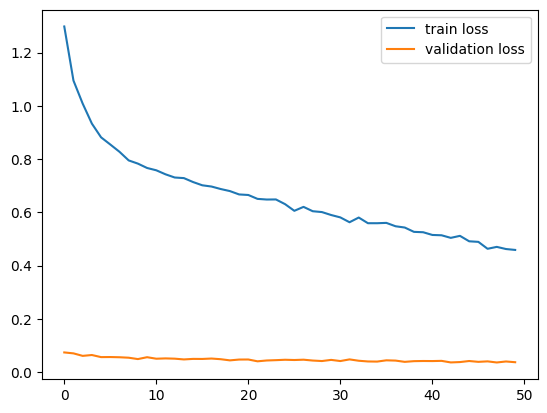

In [5]:

#train the model
#train(model, val_dataloader, val_dataloader, optimizer, criterion, 20)

train(model, train_dataloader, val_dataloader, optimizer, criterion, 50)